In [1]:
#!pip install pmdarima

Columns in dataset: Index(['rides_t-672', 'rides_t-671', 'rides_t-670', 'rides_t-669',
       'rides_t-668', 'rides_t-667', 'rides_t-666', 'rides_t-665',
       'rides_t-664', 'rides_t-663',
       ...
       'rides_t-7', 'rides_t-6', 'rides_t-5', 'rides_t-4', 'rides_t-3',
       'rides_t-2', 'rides_t-1', 'pickup_hour', 'pickup_location_id',
       'target'],
      dtype='object', length=675)
ADF Statistic: -11.116330277871196
p-value: 3.555564387839866e-20
Critical Values: {'1%': -3.431163504387491, '5%': -2.8618995109029584, '10%': -2.566961362931807}
✅ The data is stationary (p-value < 0.05). No differencing needed.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=40238.290, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40230.290, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40232.290, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=40232.290, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40234.290, Time=0.22

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 8065
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -19690.991
Date:                Wed, 05 Mar 2025   AIC                          39401.983
Time:                        16:40:56   BIC                          39471.935
Sample:                    01-29-2023   HQIC                         39425.917
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4910      0.062      7.962      0.000       0.370       0.612
ar.L1          0.8568      0.048     17.949      0.000       0.763       0.950
ar.L2          0.8823      0.049     18.124      0.0

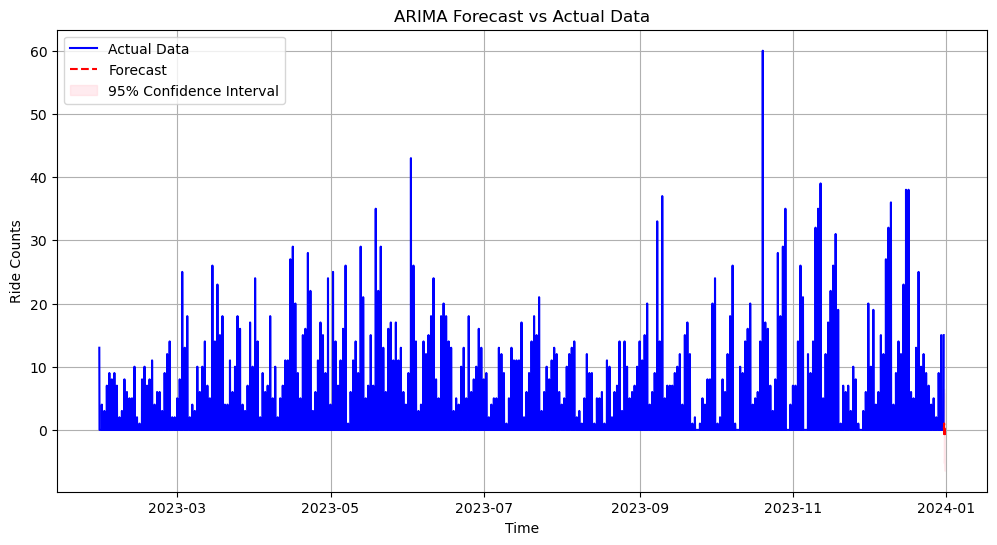

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import os

# Load time series data from a Parquet file
def load_data(parquet_path):
    """Loads time series data from a Parquet file."""
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    print("Columns in dataset:", df.columns)  # Debugging: Print available columns
    return df

# Preprocess data
def preprocess_data(df, location_id=43):
    """Filters data for a specific location and ensures a time series format."""
    if "pickup_hour" not in df.columns:
        raise KeyError("Column 'pickup_hour' not found in dataset. Available columns: " + str(df.columns))
    
    df = df[df["pickup_location_id"] == location_id]
    df = df.sort_values("pickup_hour")
    df.set_index("pickup_hour", inplace=True)
    
    # Resample to ensure all hourly timestamps are present, filling missing values with 0
    ts_data = df["target"].resample("H").sum().fillna(0)  # Summing rides per hour
    return ts_data

# Check for stationarity
def check_stationarity(ts_data):
    """Performs the Augmented Dickey-Fuller test to check for stationarity."""
    result = adfuller(ts_data)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    
    if result[1] <= 0.05:
        print("✅ The data is stationary (p-value < 0.05). No differencing needed.")
        return ts_data
    else:
        print("⚠️ The data is NOT stationary (p-value >= 0.05). Applying first-order differencing.")
        return ts_data.diff().dropna()  # Apply differencing

# Find the best ARIMA order
def find_best_arima_model(ts_data):
    """Finds the optimal ARIMA order using auto_arima."""
    best_model = auto_arima(ts_data, seasonal=False, stepwise=True, trace=True, suppress_warnings=True, error_action='ignore', max_p=5, max_q=5, max_d=2)
    print(f"Best ARIMA order: {best_model.order}")
    return best_model.order

# Fit ARIMA model
def fit_arima_model(ts_data, order):
    """Fits an ARIMA model to the time series data."""
    model = sm.tsa.ARIMA(ts_data, order=order)
    arima_result = model.fit()
    print(arima_result.summary())  # Print model diagnostics
    return arima_result

# Forecast future values
def forecast_arima_model(model, ts_data, steps=10):
    """Generates forecasts using the fitted ARIMA model."""
    forecast_result = model.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    forecast_index = pd.date_range(start=ts_data.index[-1], periods=steps + 1, freq="H")[1:]
    forecast_series = pd.Series(forecast, index=forecast_index)
    return forecast_series, conf_int

# Calculate MAE
def calculate_mae(actual, forecasted):
    """Calculates the Mean Absolute Error (MAE) between actual and forecasted values."""
    return mean_absolute_error(actual, forecasted)

# Plot actual and forecasted values with confidence intervals
def plot_forecast(ts_data, forecast_values, conf_int):
    """Plots actual data and forecasted values with confidence intervals."""
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data.index, ts_data, label="Actual Data", color='blue')
    plt.plot(forecast_values.index, forecast_values, label="Forecast", linestyle='dashed', color='red')
    plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="95% Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Ride Counts")
    plt.title("ARIMA Forecast vs Actual Data")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Define file path
    parquet_file_path = r"C:\\Users\\MD\\Desktop\\sp25_taxi-main\\data\\transformed\\tabular_data.parquet"  # Use raw string for Windows paths
    
    # Load and preprocess data
    try:
        ts_df = load_data(parquet_file_path)
        ts_series = preprocess_data(ts_df)
    
        # Check stationarity and apply differencing if needed
        ts_series = check_stationarity(ts_series)
    
        # Find the best ARIMA order
        best_order = find_best_arima_model(ts_series)
    
        # Fit ARIMA model
        arima_model = fit_arima_model(ts_series, best_order)
    
        # Forecast the next 10 time steps
        forecast_values, conf_int = forecast_arima_model(arima_model, ts_series, steps=10)
    
        # Calculate and print MAE
        mae = calculate_mae(ts_series[-10:], forecast_values[:10])
        print(f"Best ARIMA Model MAE: {mae:.4f}")
    
        # Print forecasts
        print("Forecasted Values:")
        print(forecast_values)
    
        # Plot actual vs forecasted values with confidence intervals
        plot_forecast(ts_series, forecast_values, conf_int)
    
    except Exception as e:
        print(f"Error: {e}")
